Step 1: Import library

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Install missing libraries
!pip install semopy

# ==========================
# Data & basic tools
# ==========================
import pandas as pd
import numpy as np

# ==========================
# Visualization
# ==========================
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# Statistical analysis
# ==========================
from scipy.stats import (
    ttest_ind,
    levene,
    chi2_contingency,
    skew,
    kurtosis,
    pearsonr,
    f_oneway
)
import statsmodels.api as sm

# ==========================
#  Structural Equation Modeling
# ==========================
from semopy import Model, calc_stats

# ==========================
# Time series modeling
# ==========================
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ==========================
# Machine Learning (Random Forest)
# ==========================
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==========================
# Deep Learning (LSTM)
# ==========================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 7.8 MB/s eta 0:00:00
  Created wheel for semopy: filename=semopy-2.3.11-py3-none-any.whl size=1659682 sha256=571f27a90b7144f7339e0cfc84acb3984b904166aa7db4b335ca6b9b11127ee4
  Stored in directory: /root/.cache/pip/wheels/c6/24/8b/be911b059a61f490f38425eb19bf2fed470a5ead97228e8255
Successfully built semopy


Step 2: Preprocess data

Step 2.1: Read data and drop some unused columns

In [ ]:
df = pd.read_csv("/content/household.csv")

In [ ]:
df = df.drop([
    'main',
    'description',
    'temp_min',
    'temp_max',
    'temp_t+1',
    'feels_like_t+1',
    'deg',
    'current',
    'voltage',
    'reactive_power',
    'apparent_power',
    'power_factor'
], axis=1)

Step 2.2: Load data and resample to hour

In [10]:

# change date column into datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date')

# merge data by hour (mean)
df_hour = (
    df.set_index('date')
      .resample('H')
      .mean(numeric_only=True)
      .reset_index()
)

print("The initial columns:", len(df), "→ After merging followed by hour:", len(df_hour))
df_hour

The initial columns: 495757 → After merging followed by hour: 8402


,date,active_power,temp,feels_like,pressure,humidity,speed
0,2022-11-05 14:00:00,248.780000,24.246364,23.728182,1011.909091,38.436364,0.081818
1,2022-11-05 15:00:00,202.663333,24.302000,23.765333,1010.666667,37.366667,2.912167
2,2022-11-05 16:00:00,198.863333,24.174000,23.605833,1011.416667,36.666667,2.322667
3,2022-11-05 17:00:00,390.181667,23.485667,22.830667,1010.600000,36.083333,2.455000
4,2022-11-05 18:00:00,443.036667,21.693667,20.933333,1008.816667,38.783333,2.269500
...,...,...,...,...,...,...,...
8397,2023-10-21 11:00:00,113.313333,24.574833,23.777833,1018.350000,29.333333,0.145500
8398,2023-10-21 12:00:00,92.703333,26.626000,26.377333,1014.850000,25.666667,0.304000
8399,2023-10-21 13:00:00,124.131667,27.391000,26.473167,1014.000000,24.566667,3.034000
8400,2023-10-21 14:00:00,113.475000,27.848667,26.856000,1008.816667,26.583333,3.059833


Step 2.3: Prepare some data columns

In [11]:


df_hour['weekday'] = df_hour['date'].dt.weekday
df_hour['is_weekend'] = df_hour['weekday'].isin([5,6]).astype(int)

# Lag features
df_hour['ap_lag_1h'] = df_hour['active_power'].shift(1)
df_hour['ap_lag_24h'] = df_hour['active_power'].shift(24)
df_hour['ap_roll_24h'] = df_hour['active_power'].rolling(24, min_periods=1).mean()
df_hour.dropna(inplace=True)

In [12]:
df_hour.head(1)

,date,active_power,temp,feels_like,pressure,humidity,speed,weekday,is_weekend,ap_lag_1h,ap_lag_24h,ap_roll_24h
24,2022-11-06 14:00:00,163.376667,28.653167,27.250167,1013.916667,21.083333,3.781167,6,1,224.355,248.78,273.720891


Step 3.7: LSTM Deep Learning Model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.0170 - val_loss: 0.0250
Epoch 2/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0123 - val_loss: 0.0267
Epoch 3/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0111 - val_loss: 0.0249
Epoch 4/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0113 - val_loss: 0.0226
Epoch 5/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0109 - val_loss: 0.0265
Epoch 6/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0109 - val_loss: 0.0219
Epoch 7/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0105 - val_loss: 0.0284
Epoch 8/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0102 - val_loss: 0.0191
Epoch 9/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0099 - val_loss: 0.0182
Epoch 10/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0096 - val_loss: 0.0168
Epoch 11/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0095 - val_loss: 0.0182
Epoch 12/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 

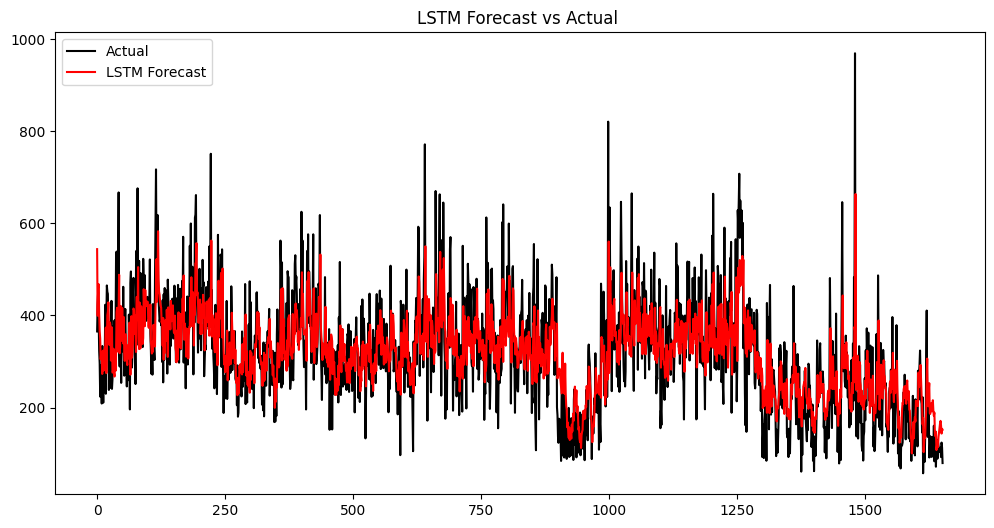

In [ ]:


# ================================
# 1. Select features for LSTM
# ================================
features = ['active_power', 'temp', 'humidity', 'pressure', 'speed',
            'ap_lag_1h', 'ap_lag_24h', 'ap_roll_24h']

df_lstm = df_hour[features].copy().dropna()

# ================================
# 2. Scale the data
# ================================
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_lstm)

# ================================
# 3. TCreate sequences (windows)
# ================================
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i, 0])   # column 0 = active_power
    return np.array(X), np.array(y)

window_size = 24   # use the past 24 hours to forecast the next hour

X, y = create_sequences(scaled_data, window_size)

# ================================
# 4. TRAIN/TEST SPLIT
# ================================
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ================================
# 5. Build the LSTM model
# ================================
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(window_size, X.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(32))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

# ================================
# 6. TRAIN MODEL
# ================================
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1,
                    verbose=1)

# ================================
# 7. Forecasting
# ================================
y_pred = model.predict(X_test)

# Inverse scale prediction
test_scaled = np.zeros((len(y_pred), scaled_data.shape[1]))
test_scaled[:, 0] = y_pred[:, 0]

y_pred_inv = scaler.inverse_transform(test_scaled)[:, 0]
y_test_inv = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1,1), np.zeros((len(y_test), scaled_data.shape[1]-1))], axis=1)
)[:, 0]

# ================================
# 8. Evaluation
# ================================
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"LSTM → MAE={mae:.4f}, RMSE={rmse:.4f}")

# ================================
# 9. Plot the results
# ================================
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual', color='black')
plt.plot(y_pred_inv, label='LSTM Forecast', color='red')
plt.legend()
plt.title("LSTM Forecast vs Actual ")
plt.show()
